In [1]:

import sys
sys.path.append('../')
from fit.datamodules.super_res import MNIST_SResFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D
from fit.utils.utils import denormalize, denormalize_amp, denormalize_phi

from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt
from matplotlib import gridspec
from fit.transformers.PSNR import RangeInvariantPsnr as PSNR
# from fit.utils.utils import PSNR
import torch

import numpy as np
import pandas as pd
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import exists
import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import scipy
seed_everything(22122020)
dm = MNIST_SResFITDM(root_dir='./datamodules/data/', batch_size=32)
dm.prepare_data(subset_flag=False)
dm.setup()
r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)
n_heads = 8
d_query = 32
model = SResTransformerModule(d_model=n_heads*d_query, 
                              img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss='prod',
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query, dropout=0.1, attention_dropout=0.1,num_shells = 5,
                              model_type = 'torch')
fig = plt.figure()
psnr_dict = {}
trained_model_path = '/home/aman.kukde/Projects/FourierImageTransformer/models/Torch_prod__L_8_H_8_s_5_subset_False_26-03_20-10-16/epoch=171-step=295668.ckpt'#,'/home/aman.kukde/Projects/FourierImageTransformer/models_saved/Run_07-03_15-04-41_sum_modified_overfitted_114/epoch=943-step=944.ckpt']
weights = torch.load(trained_model_path)['state_dict']
model.load_state_dict(weights)
model.cuda()
model.eval()

trainer = Trainer(max_epochs=100, 
                #gpus=1, # set to 0 if you want to run on CPU
                callbacks=ModelCheckpoint(
                                            dirpath=None,
                                            save_top_k=1,
                                            verbose=False,
                                            save_last=True,
                                            monitor='Validation/avg_val_loss',
                                            mode='min'
                                        ), 
                deterministic=True)



/localscratch/miniforge3/envs/FIT_LS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 22122020


Using full MNIST dataset


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<Figure size 640x480 with 0 Axes>

In [2]:
for fc, (mag_min, mag_max) in dm.test_dataloader():
    break
# for fc, (mag_min, mag_max) in dm.train_dataloader():
#     break
fc = fc.to('cuda')
mag_min = mag_min.to('cuda')
mag_max = mag_max.to('cuda')
x_fc = fc[:, flatten_order][:, :model.input_seq_length]
# x_fc = fc[:, flatten_order][:, :-1]
gt = fc[:, flatten_order]
# pred = model.sres.forward_i(x_fc,model.input_seq_length)
pred = model.sres.forward_inference(x_fc,model.input_seq_length)
pred_forward = model.sres.forward(fc[:,:-1])

pref_forward_img = model.convert2img(fc=pred_forward, mag_min=mag_min, mag_max=mag_max)
lowres_img = model.convert2img(fc=x_fc, mag_min=mag_min, mag_max=mag_max)
pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)
gt_img = model.convert2img(fc=gt, mag_min=mag_min, mag_max=mag_max)
pred_img = denormalize(pred_img, dm.mean, dm.std)
gt_img = denormalize(gt_img, dm.mean, dm.std)


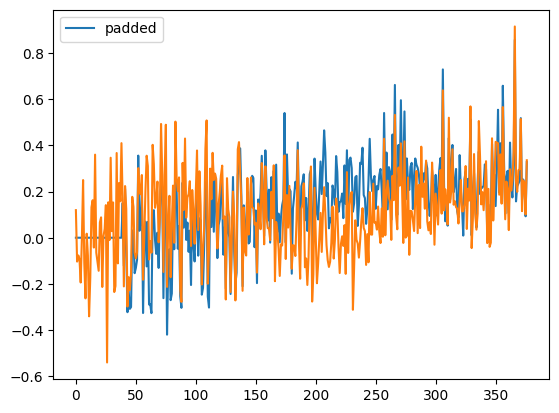

In [3]:
a = (pred[0]-gt[0,:-1])[:,0][:]
a2 = (pred_forward[0]-gt[0,:-1])[:,0][:]
a = a.detach().cpu().numpy()
a2 = a2.detach().cpu().numpy()
plt.plot([i for i in range(len(pred[0]))],a,label = 'padded')
plt.plot([i for i in range(len(pred_forward[0]))],a2)
plt.legend()

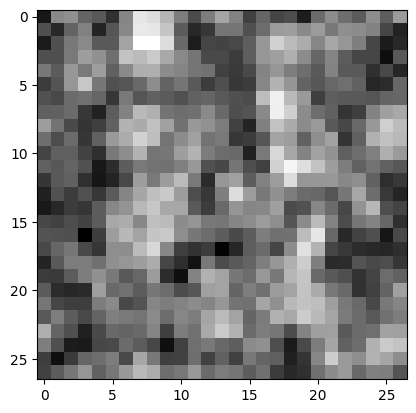

In [7]:
plt.imshow(pref_forward_img.detach().cpu().numpy()[0],cmap='gray')

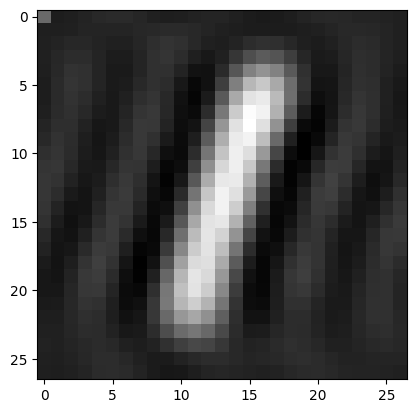

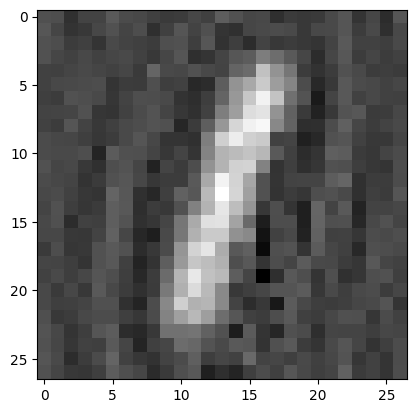

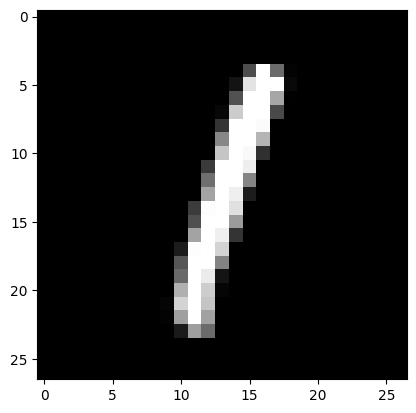

In [ ]:
plt.imshow(lowres_img[5].cpu().detach().numpy(), cmap='gray');plt.show()
plt.imshow(pred_img[5].cpu().detach().numpy(), cmap='gray');plt.show()
plt.imshow(gt_img[5].cpu().detach().numpy(), cmap='gray')

In [ ]:
PSNR(gt_img, pred_img)

tensor([15.0284, 13.7290, 18.2278, 14.7201, 14.6080, 18.4091, 14.3505, 15.3977,
        14.0700, 13.9673, 13.9363, 13.5583, 14.4875, 14.3349, 17.1925, 13.7213,
        13.9867, 14.8843, 13.3100, 15.5435, 14.7731, 14.7240, 14.0243, 14.2561,
        16.0240, 14.5026, 15.3601, 14.6262, 13.5952, 17.5734, 14.8975, 17.7052],
       device='cuda:0')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


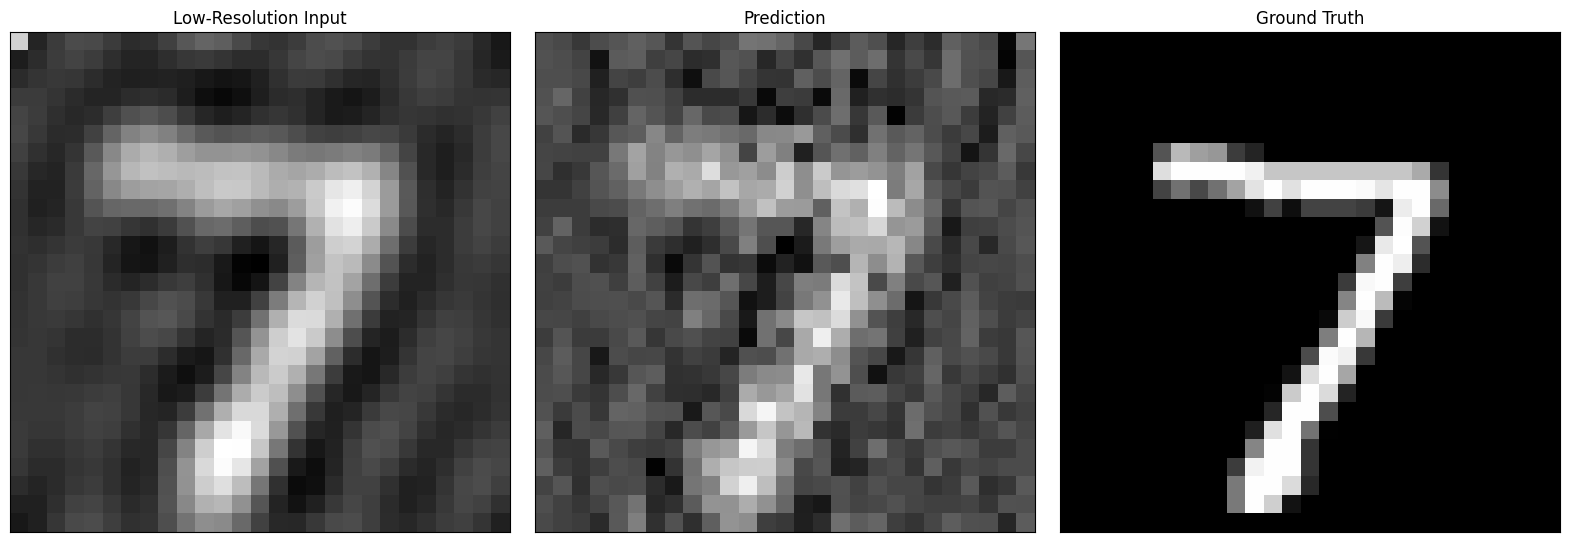

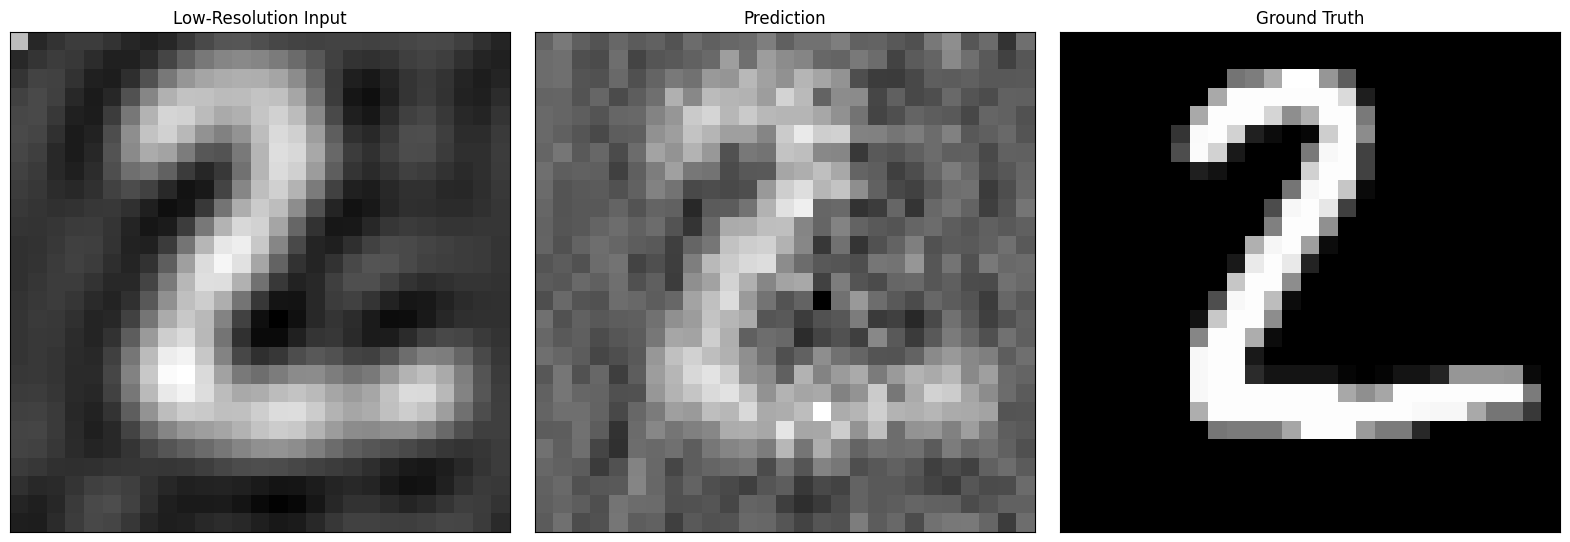

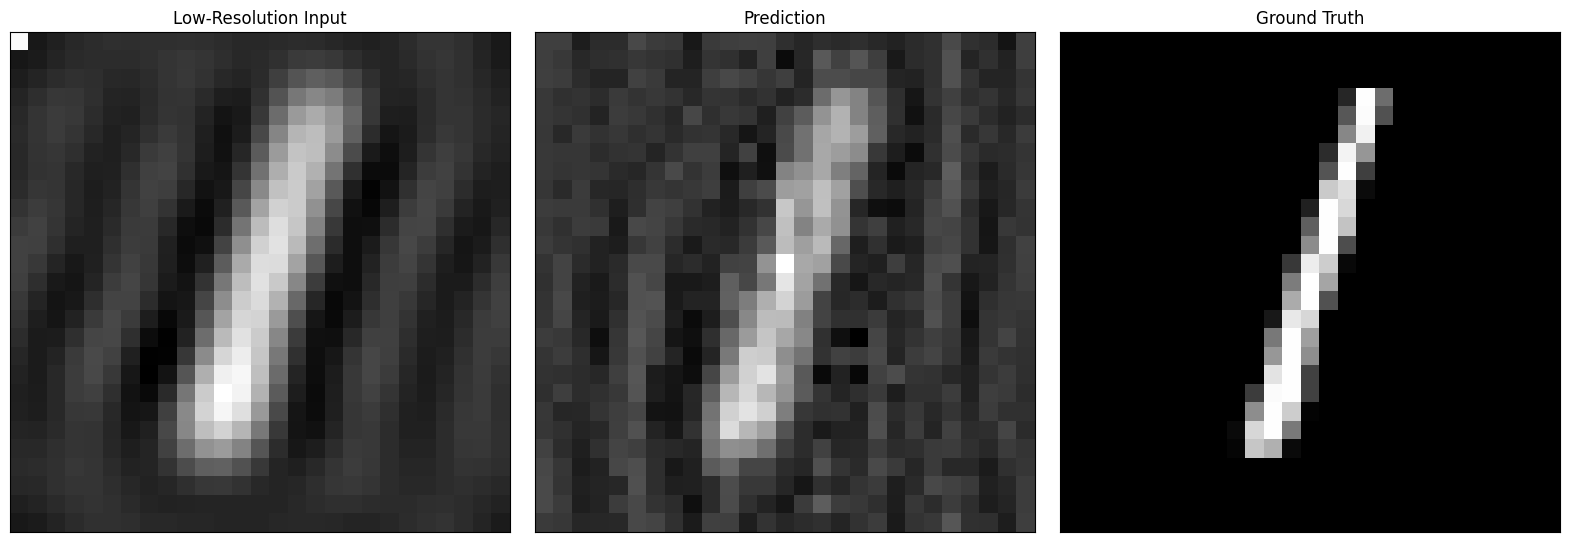

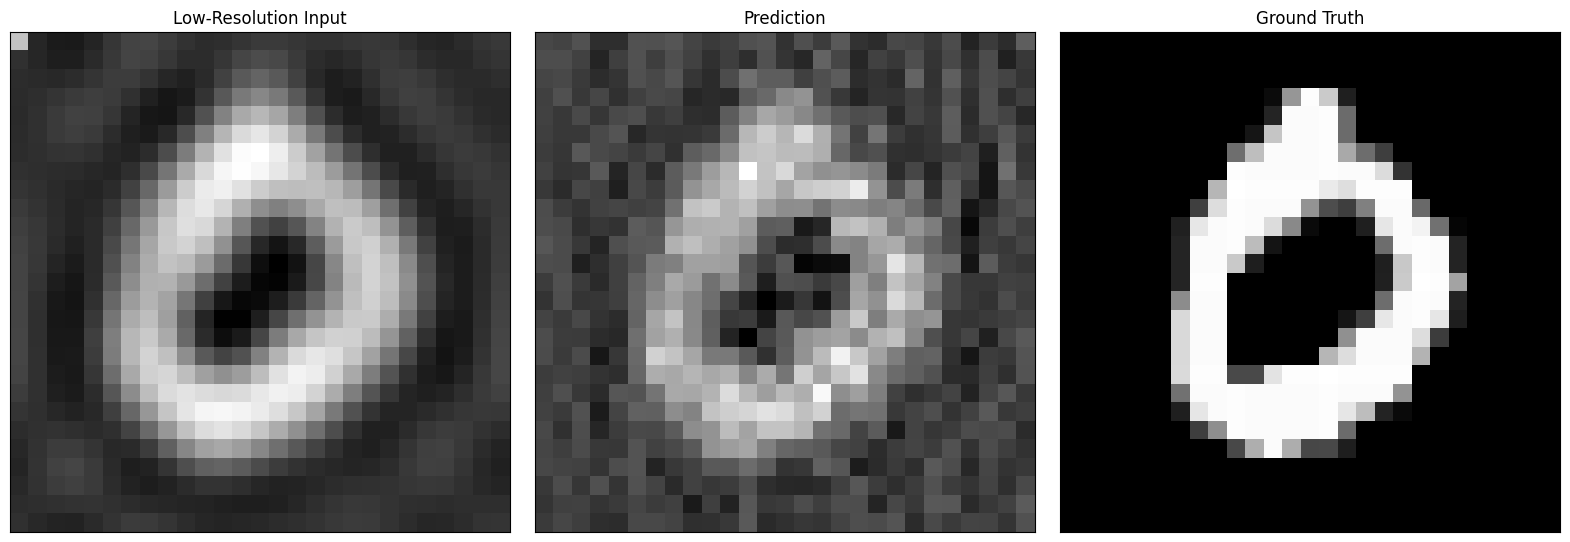

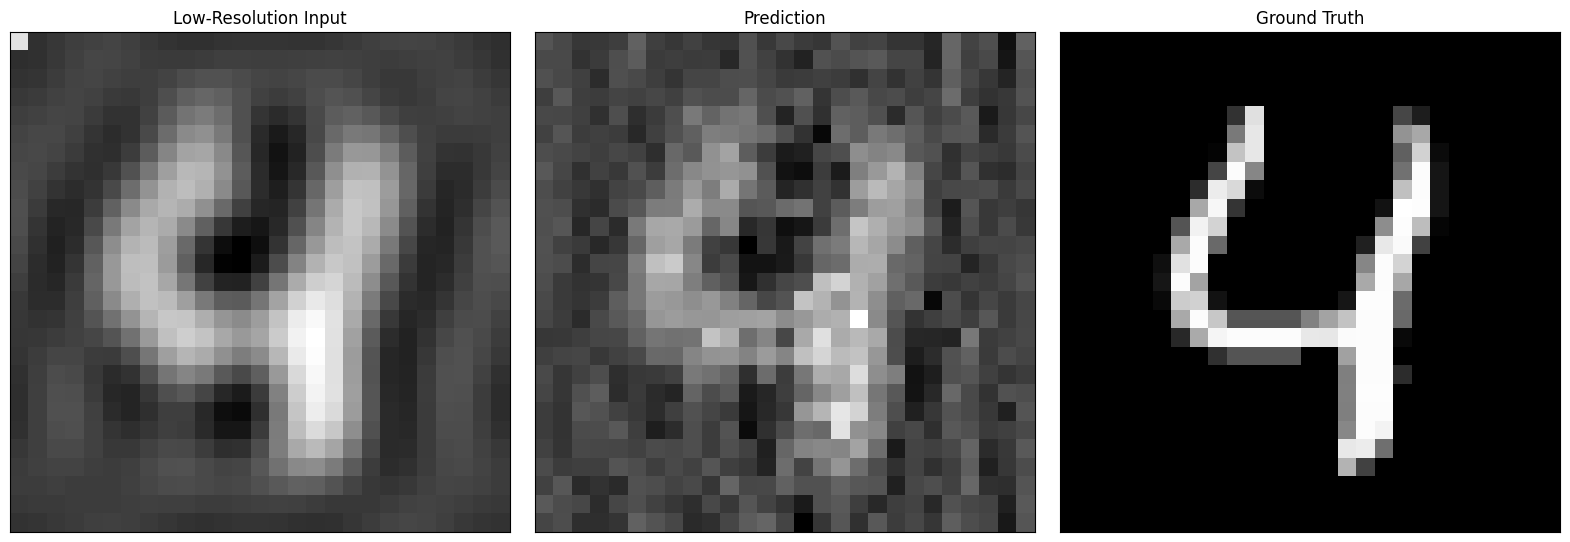

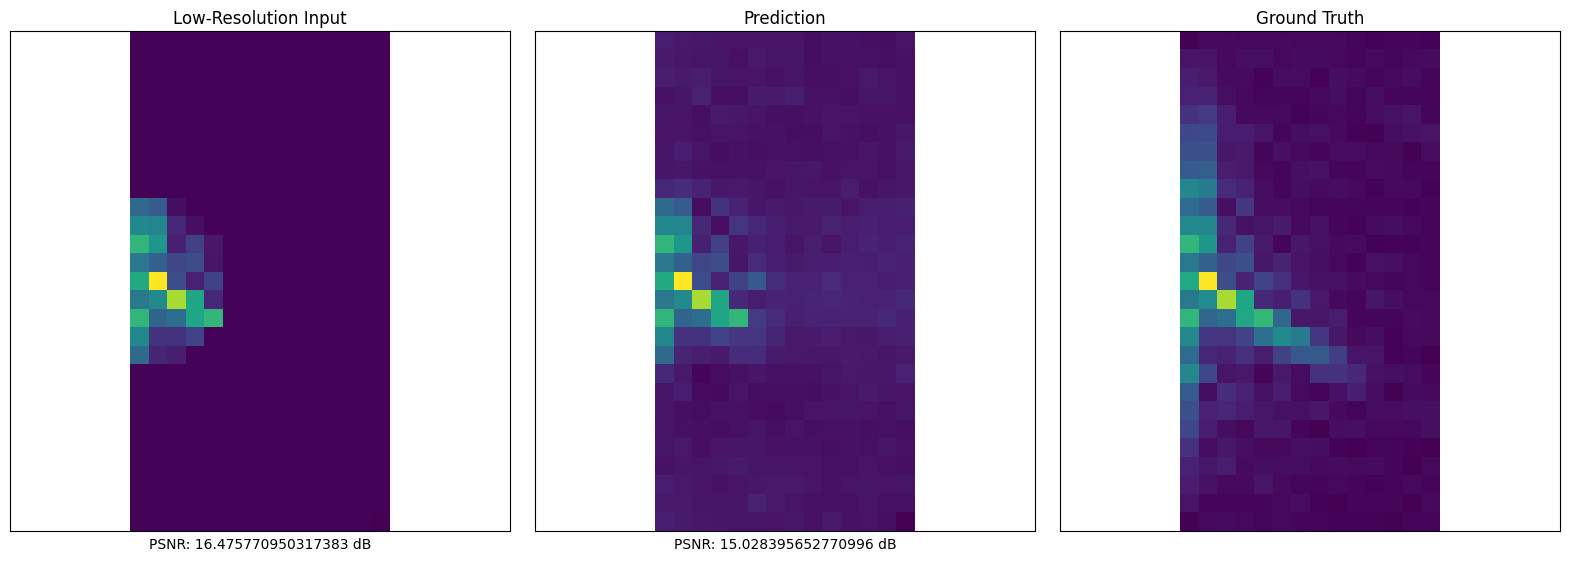

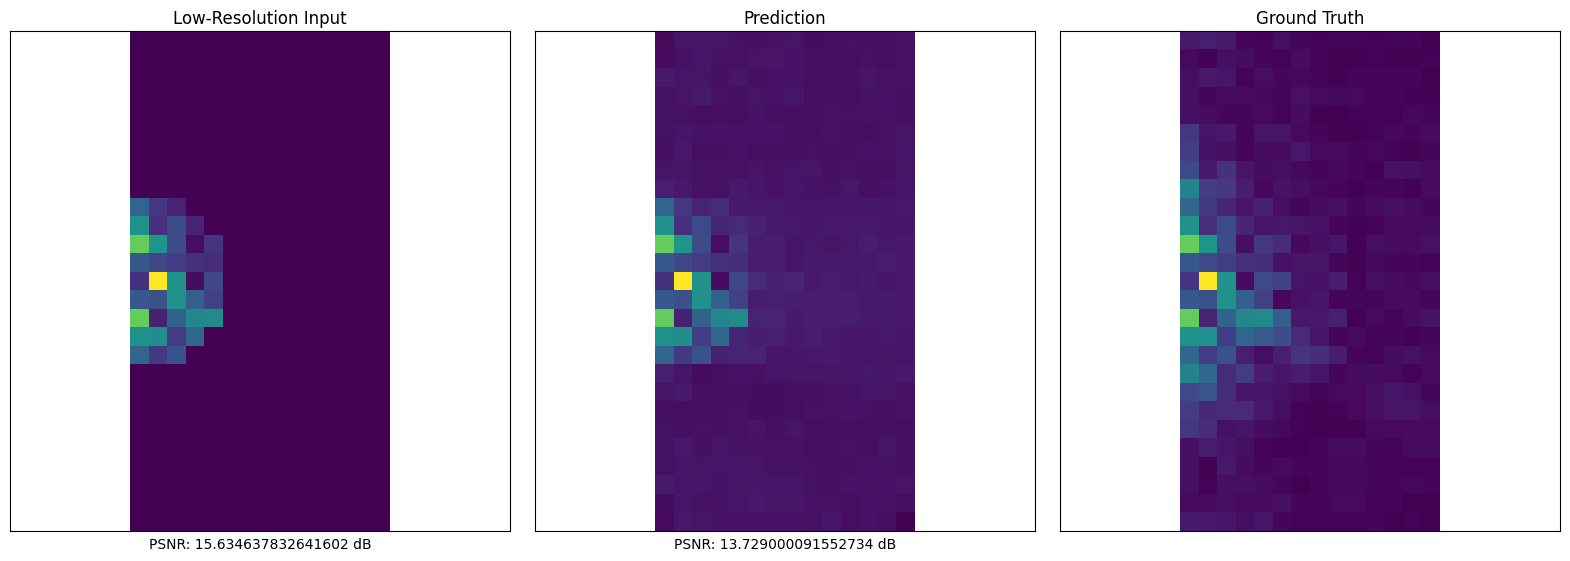

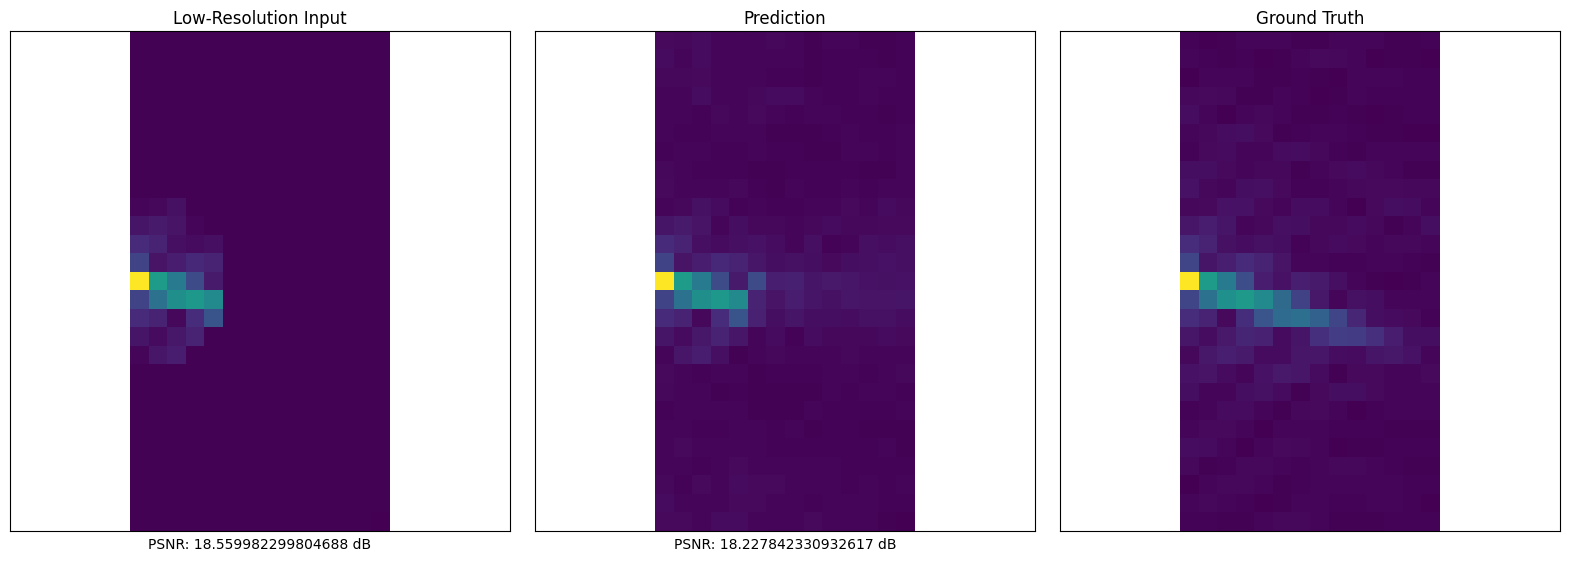

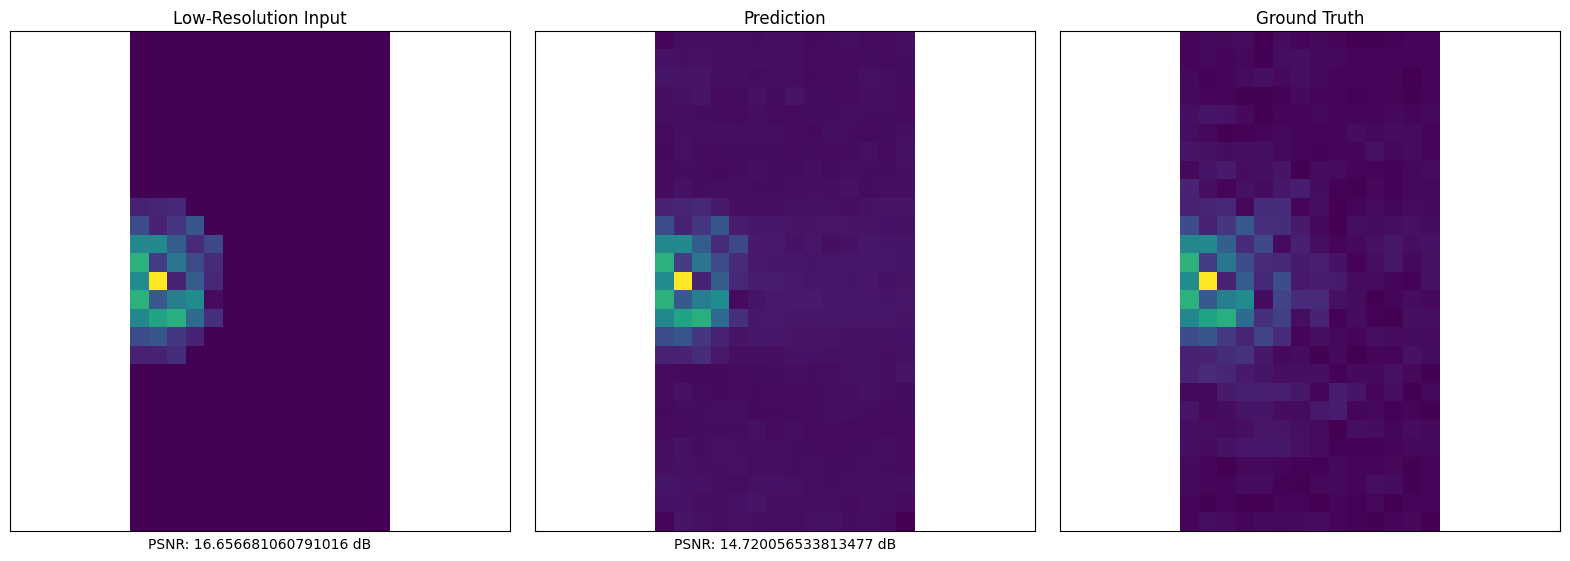

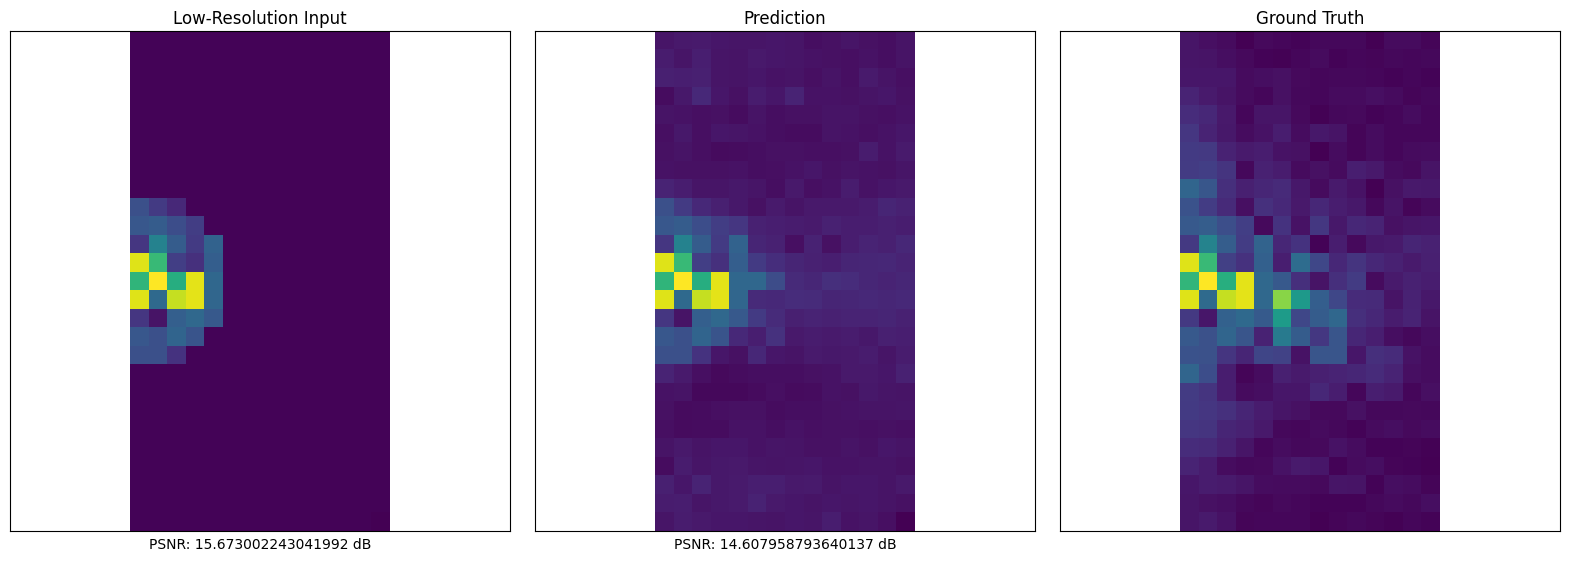

In [ ]:

# for fc, (mag_min, mag_max) in dm.test_dataloader():
#     break
# # for fc, (mag_min, mag_max) in dm.train_dataloader():
# #     break
# fc = fc.to('cuda')
# mag_min = mag_min.to('cuda')
# mag_max = mag_max.to('cuda')
# x_fc = fc[:, flatten_order][:, :model.input_seq_length]
# pred = model.sres.forward_i(x_fc,model.input_seq_length)
# # pred[:,96:] = (pred[:,96:] - pred[:,96:].min()) / (pred[:,96:].max() - pred[:,96:].min())
pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)

                    
lowres = torch.zeros_like(pred)
# lowres += fc.min()
lowres[:, :model.input_seq_length] = fc[:, model.dst_flatten_order][:, :model.input_seq_length]
lowres_img = model.convert2img(fc=lowres, mag_min=mag_min, mag_max=mag_max)
gt_img = model.convert2img(fc=fc[:, model.dst_flatten_order], mag_min=mag_min, mag_max=mag_max)


lowres_psnr = PSNR(gt_img,lowres_img)
pred_psnr = PSNR(gt_img,pred_img)
model_no = 0
psnr_dict[str(model_no)] = pred_psnr.cpu().detach() - lowres_psnr.cpu().detach()

sns.histplot(pred_psnr.cpu().detach() - lowres_psnr.cpu().detach(), kde=True, color='green', legend= True, label = "model_no = "+str(model_no))
fig.legend()
plt.savefig('psnr_diff.png')
plt.close()
for i in [pred_img, lowres_img, gt_img]:
    i.cpu().detach().numpy()
for sample in range(5):
    fig2 = plt.figure(figsize=(31/2., 10/2.)) 
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)

    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    ax0.imshow(lowres_img[sample].cpu(), cmap='gray')
    ax0.set_title('Low-Resolution Input');
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.imshow(pred_img[sample].cpu(), cmap='gray')
    ax1.set_title('Prediction');
    ax1.axis('equal');


    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(gt_img[sample].cpu(), cmap='gray')
    ax2.set_title('Ground Truth');
    ax2.axis('equal');

from sklearn.random_projection import sample_without_replacement


diff = []
for i in range(5):
    sample = i
    # pred_img[i] = (pred_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
    # lowres_img[i] = (lowres_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
    fig = plt.figure(figsize=(31/2., 10/2.))
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)
    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    lowres_psnr = PSNR(gt_img, lowres_img)
    # lowres_img_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], lowres_img[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),13,0))
    ax0.set_title('Low-Resolution Input');
    ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),13,0))
    pred_psnr = PSNR(gt_img, pred_img)
    # pred_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], pred_img[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax1.set_title('Prediction');
    ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
    ax1.axis('equal');

    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),13,0))
    ax2.set_title('Ground Truth');
    # ax2.set_xlabel(f'Max: {gt_img[sample].cpu().max():.2f} Min: {gt_img[sample].cpu().min():.2f}');
    ax2.axis('equal');
    diff.append(lowres_psnr - pred_psnr)
    

In [ ]:
x_fc.shape

torch.Size([32, 39, 2])

In [ ]:
pred[0,:96]-  x_fc[0,:96]

RuntimeError: The size of tensor a (96) must match the size of tensor b (39) at non-singleton dimension 0

In [ ]:
np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),13,0).shape

In [ ]:
for i in [pred_img, lowres_img, gt_img]:
    i.cpu().detach().numpy()
for sample in range(5):
    fig = plt.figure(figsize=(31/2., 10/2.)) 
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)

    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    ax0.imshow(lowres_img[sample].cpu(), cmap='gray')
    ax0.set_title('Low-Resolution Input');
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.imshow(pred_img[sample].cpu(), cmap='gray')
    ax1.set_title('Prediction');
    ax1.axis('equal');


    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(gt_img[sample].cpu(), cmap='gray')
    ax2.set_title('Ground Truth');
    ax2.axis('equal');

In [ ]:
from sklearn.random_projection import sample_without_replacement


diff =[]
for i in range(1):
    sample = i
    # pred_img[i] = (pred_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
    # lowres_img[i] = (lowres_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
    fig = plt.figure(figsize=(31/2., 10/2.))
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)
    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    lowres_psnr = PSNR(gt_img, lowres_img)
    # lowres_img_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], lowres_img[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),13,0))
    ax0.set_title('Low-Resolution Input');
    ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),13,0))
    pred_psnr = PSNR(gt_img, pred_img)
    # pred_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], pred_img[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax1.set_title('Prediction');
    ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
    ax1.axis('equal');

    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),13,0))
    ax2.set_title('Ground Truth');
    # ax2.set_xlabel(f'Max: {gt_img[sample].cpu().max():.2f} Min: {gt_img[sample].cpu().min():.2f}');
    ax2.axis('equal');
    diff.append(lowres_psnr - pred_psnr)

In [ ]:
sns.boxplot(lowres_psnr.cpu().detach().numpy())
sns.boxplot(pred_psnr.cpu().detach().numpy())